In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from collections import defaultdict
import torchvision.models as models
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import random
import pickle
import razdel
import torch
import json
import re

from dataset import DecoderDataset
from vocabulary import Vectorizer
from autoencoder import Autoencoder
from decoder import Decoder, AttentionDecoder

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32

In [2]:
datasets_train_paths = [
    'D:/Вера/Диплом/Датасеты/flicker_train.pickle',
    # 'D:/Вера/Диплом/Датасеты/GCC_train.pickle',
    # 'D:/Вера/Диплом/Датасеты/coco_train.pickle',
]
dataset_test_paths = [
    'D:/Вера/Диплом/Датасеты/all_test.pickle'
]
all_captions_path = 'C:/Users/ivanb/Downloads/Telegram Desktop/all_captions.csv'

In [3]:
vectorizer = Vectorizer(pd.read_csv(all_captions_path)['translations'])

In [7]:
decoder_dataset = DecoderDataset(datasets_train_paths, vectorizer)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.57s/it]


In [4]:
test_decoder_dataset = DecoderDataset(dataset_test_paths, vectorizer)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.28s/it]


In [9]:
loader = DataLoader(decoder_dataset, batch_size=batch_size, shuffle=True)

In [25]:
embed_size = 512
hidden_size = 512
vocab_size = len(vectorizer)
num_layers = 1
learning_rate = 1e-3
num_epochs = 100

model = Decoder(embed_size, hidden_size, vocab_size, num_layers, vectorizer).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.unknown_idx)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

name = "captioning_exp_all_datasets"

config = {
    "name": f"{name}_config.json",
    "datasets": datasets_train_paths,
    "learning_rate": learning_rate,
    "loss": {
        "ignore_index": "vectorizer.unknown_idx"
    },
    "num_epochs": num_epochs,
    "num_layers": num_layers,
    "hidden_size" : hidden_size,
}

losses = []

In [26]:
for epoch in range(num_epochs):
    acc_loss = 0
    n_batches = 0
    model.train()
    model.to(device)
    for idx, (imgs, captions) in tqdm(enumerate(loader)):
        n_batches += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:, :-1]) 
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
        del imgs, captions, outputs, loss
        torch.cuda.empty_cache()
    
    mean_loss = acc_loss / n_batches
    losses.append(mean_loss)
    print(f"epoch={epoch} mean_loss={mean_loss:.2f}")
    model.eval()
    i=random.randint(0, len(test_decoder_dataset)-1)
    test_demo = model.to('cpu').caption_image(test_decoder_dataset[i][0], vectorizer, vectorizer.max_len)
    print(f'TEST DEMO\nReal caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {test_demo}')
    torch.save(model, f"{name}_weights.pt")

750it [02:45,  4.53it/s]


epoch=0 mean_loss=1.17
[2, 8, 4, 37, 19, 7, 162, 115, 7, 19, 6, 301, 636, 16, 5, 347, 18, 118, 3]
TEST DEMO
Real caption: <SOS> мотоциклист стоит рядом со своим черным мотоциклом в то время как в небе горит красный сигнал светофора <EOS>
Predict: <SOS> мужчина в белой рубашке и черных шортах и рубашке с длинными рукавами стоит на коленях перед зданием <EOS>


22it [00:06,  3.60it/s]


KeyboardInterrupt: 

In [5]:
embed_size=512
attention_dim=512
encoder_size=512
hidden_size=512
num_epochs=180
learning_rate=1e-3

model = AttentionDecoder(embed_size=embed_size, hidden_size=hidden_size, encoder_size=encoder_size, attention_dim=attention_dim, vocab=vectorizer).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

name = "captioning_flicker_attention_pos_embedding"

config = {
    "name": f"{name}_config.json",
    "datasets": datasets_train_paths,
    "learning_rate": learning_rate,
    "loss": {
        "ignore_index": "vectorizer.unknown_idx"
    },
    "num_epochs": num_epochs,
    "hidden_size" : hidden_size,
}

losses = []

In [6]:
model.load_state_dict(torch.load('models/captioning_flickr_attention_pos_embedding_weights.pt'))

<All keys matched successfully>

In [ ]:
for epoch in range(num_epochs):
    acc_loss = 0
    n_batches = 0
    model.train()
    model.to(device)
    for idx, (imgs, captions) in tqdm(enumerate(loader)):
        n_batches += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs, attentions = model(imgs, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
        del imgs, captions, outputs, loss
        torch.cuda.empty_cache()
    
    mean_loss = acc_loss / n_batches
    losses.append(mean_loss)
    print(f"epoch={epoch} mean_loss={mean_loss:.2f}")
    model.eval()
    model.cpu()
    i=random.randint(0, len(test_decoder_dataset)-1)
    test_demo = model.greedy_decode(test_decoder_dataset[i][0].unsqueeze(0))
    print(f'TEST DEMO\nReal caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {vectorizer.decode(test_demo)}')
    torch.save(model.state_dict(), f"{name}_weights.pt")

750it [07:02,  1.77it/s]


epoch=0 mean_loss=1.26
TEST DEMO
Real caption: <SOS> два жирафа за стеной из валунов перед воротами <EOS>
Predict: <SOS> мужчина в белой рубашке и джинсах и <UNK> <UNK> <UNK> <UNK> <EOS>


750it [07:00,  1.78it/s]


epoch=1 mean_loss=0.98
TEST DEMO
Real caption: <SOS> большие белые часы стоящие на стене старого <UNK> здания <EOS>
Predict: <SOS> мужчина в белой рубашке и синих джинсах стоит на улице перед зданием <EOS>


750it [06:59,  1.79it/s]


epoch=2 mean_loss=0.87
TEST DEMO
Real caption: <SOS> внешний вид <UNK> магазина <UNK> традиционное <UNK> влияние в городе <EOS>
Predict: <SOS> мужчина в синей рубашке и синих джинсах стоит на тротуаре перед зданием <EOS>


750it [06:59,  1.79it/s]


epoch=3 mean_loss=0.80
TEST DEMO
Real caption: <SOS> векторная иллюстрация древнего <UNK> <UNK> <EOS>
Predict: <SOS> мужчина в белой рубашке и синих джинсах стоит на коленях на полу с <UNK> <UNK> <EOS>


750it [07:01,  1.78it/s]


epoch=4 mean_loss=0.73
TEST DEMO
Real caption: <SOS> человек <UNK> мечеть на <UNK> фоне <EOS>
Predict: <SOS> группа людей стоит на коленях на полу и смотрит на них <EOS>


750it [07:00,  1.78it/s]


epoch=5 mean_loss=0.67
TEST DEMO
Real caption: <SOS> <UNK> местность в городе с вывеской с мультяшным персонажем поблизости <EOS>
Predict: <SOS> мужчина в красной рубашке и синих джинсах стоит на улице с двумя детьми в то время как мужчина в черной рубашке и шляпе стоит на заднем плане <EOS>


750it [07:00,  1.78it/s]


epoch=6 mean_loss=0.62
TEST DEMO
Real caption: <SOS> можно увидеть множество бурых коров прогуливающихся по травянистому полю <EOS>
Predict: <SOS> группа людей стоит на траве и смотрит на чтото в то время как мужчина в синей рубашке и джинсах стоит на заднем плане <EOS>


750it [07:02,  1.77it/s]


epoch=7 mean_loss=0.58
TEST DEMO
Real caption: <SOS> день <UNK> невесты <UNK> по саду с зонтиком <EOS>
Predict: <SOS> мужчина в красной рубашке и синих джинсах стоит на коленях на улице в то время как женщина в красной рубашке наблюдает за происходящим <EOS>


750it [07:02,  1.77it/s]


epoch=8 mean_loss=0.54
TEST DEMO
Real caption: <SOS> красочный бесшовный <UNK> узор с тропическими листьями и цветами на белом фоне <EOS>
Predict: <SOS> маленький ребенок в красной рубашке и синих джинсах лежит на земле рядом с большим транспортным средством <EOS>


750it [07:03,  1.77it/s]


epoch=9 mean_loss=0.51
TEST DEMO
Real caption: <SOS> внешний вид <UNK> магазина <UNK> традиционное <UNK> влияние в городе <EOS>
Predict: <SOS> мужчина в синей рубашке и синих брюках стоит на тротуаре перед зданием <EOS>


750it [07:09,  1.75it/s]


epoch=10 mean_loss=0.48
TEST DEMO
Real caption: <SOS> многочисленные работники в синих рубашках и белых фартуках готовят рыбу на продажу <EOS>
Predict: <SOS> группа людей сидит в универмаге и работает на столе <EOS>


750it [07:01,  1.78it/s]


epoch=11 mean_loss=0.46
TEST DEMO
Real caption: <SOS> ярко раскрашенная птица сидит на ветке <UNK> дерева <EOS>
Predict: <SOS> мужчина в зеленой рубашке и шляпе с длинными рукавами сидит на корточках на скамейке <EOS>


750it [07:02,  1.77it/s]


epoch=12 mean_loss=0.44
TEST DEMO
Real caption: <SOS> судья в своем кресле в день <EOS>
Predict: <SOS> группа людей стоит на сцене и смотрит на чтото в то время как другой мужчина в черной рубашке и джинсах стоит на лестнице <EOS>


750it [07:02,  1.78it/s]


epoch=13 mean_loss=0.42
TEST DEMO
Real caption: <SOS> очень маленькая ванная комната с парой <UNK> на полу <EOS>
Predict: <SOS> мужчина в белой рубашке и черных брюках сидит на стуле перед фреской <EOS>


750it [07:01,  1.78it/s]


epoch=14 mean_loss=0.40
TEST DEMO
Real caption: <SOS> двое мужчин сидят на скале у берега океана а рядом стоит еще один мужчина <EOS>
Predict: <SOS> мужчина в белой рубашке и шортах стоит на пляже и смотрит на воду <EOS>


750it [07:02,  1.77it/s]


epoch=15 mean_loss=0.38
TEST DEMO
Real caption: <SOS> две половинки <UNK> на тарелке на столе <EOS>
Predict: <SOS> мужчина в белой рубашке и синих джинсах сидит на красном стуле <EOS>


750it [07:01,  1.78it/s]


epoch=16 mean_loss=0.37
TEST DEMO
Real caption: <SOS> это мои волосы после душа <EOS>
Predict: <SOS> мужчина в желтой рубашке и синих джинсах сидит на полу с закрытыми глазами и <UNK> перед собой <EOS>


750it [07:02,  1.77it/s]


epoch=17 mean_loss=0.35
TEST DEMO
Real caption: <SOS> две девочки во дворе у одной в руках стакан а у другой бейсбольная бита <EOS>
Predict: <SOS> женщина в белой рубашке и черных шортах стоит на траве и смотрит на нее <EOS>


750it [07:02,  1.78it/s]


epoch=18 mean_loss=0.34
TEST DEMO
Real caption: <SOS> гостиная с телевизором и развлекательным центром рядом со скульптурой торса <EOS>
Predict: <SOS> мужчина в черной рубашке и джинсах сидит на скамейке в то время как женщина в черном платье стоит у двери и наблюдает за происходящим <EOS>


750it [07:02,  1.78it/s]


epoch=19 mean_loss=0.33
TEST DEMO
Real caption: <SOS> перекресток с уличными знаками и машинами рядом с кирпичным зданием <EOS>
Predict: <SOS> мужчина в красной рубашке и синих джинсах стоит на тротуаре рядом с улицей <EOS>


750it [07:01,  1.78it/s]


epoch=20 mean_loss=0.32
TEST DEMO
Real caption: <SOS> <UNK> женщина одетая как танцовщица живота протягивает ткань с бисером на ней <EOS>
Predict: <SOS> женщина в белой рубашке и синих джинсах стоит перед входом в <UNK> <EOS>


750it [07:02,  1.77it/s]


epoch=21 mean_loss=0.31
TEST DEMO
Real caption: <SOS> яркожелтое такси проезжает по оживленной улице в многолюдном районе <EOS>
Predict: <SOS> мужчина в черной рубашке и синих джинсах стоит на тротуаре перед зданием <EOS>


750it [07:01,  1.78it/s]


epoch=22 mean_loss=0.30
TEST DEMO
Real caption: <SOS> ребенок поднимает руку стоя на краю фонтана во внутреннем дворе и вода <UNK> через край <EOS>
Predict: <SOS> мужчина в белой рубашке и синих брюках стоит на тротуаре рядом с вывеской <UNK> <UNK> <EOS>


750it [07:01,  1.78it/s]


epoch=23 mean_loss=0.29
TEST DEMO
Real caption: <SOS> <UNK> трава ранним утром <EOS>
Predict: <SOS> маленькая девочка в красном платье и рюкзаке фотографирует мальчика в <UNK> <EOS>


750it [07:02,  1.78it/s]


epoch=24 mean_loss=0.28
TEST DEMO
Real caption: <SOS> юная девочкаподросток азиатского происхождения плавает внутри большой чаши в водоеме используя весло <EOS>
Predict: <SOS> женщина в розовом бикини и белой шляпе держит в руках <UNK> <UNK> <EOS>


750it [07:00,  1.79it/s]


epoch=25 mean_loss=0.27
TEST DEMO
Real caption: <SOS> дом окружен белым штакетником <EOS>
Predict: <SOS> группа людей сидит на улице перед зданием <EOS>


750it [06:59,  1.79it/s]


epoch=26 mean_loss=0.26
TEST DEMO
Real caption: <SOS> король <UNK> толпе <EOS>
Predict: <SOS> мужчина в красной рубашке и галстуке в <UNK> полоску стоит на сцене с <UNK> <UNK> и <UNK> <EOS>


750it [06:58,  1.79it/s]


epoch=27 mean_loss=0.26
TEST DEMO
Real caption: <SOS> маленький ребенок в розовой футболке и соломенной шляпе стоит перед киоском на уличном рынке <EOS>
Predict: <SOS> мужчина в синей рубашке и шляпе держит в руках <UNK> <UNK> <UNK> <UNK> в то время как другой мужчина в белой рубашке и джинсах протягивает руку в то время как другой мужчина сидит и смотрит на него <EOS>


750it [06:58,  1.79it/s]


epoch=28 mean_loss=0.25
TEST DEMO
Real caption: <SOS> жокей в фиолетовой рубашке скачет на коричневой <UNK> лошади по травяной дорожке <EOS>
Predict: <SOS> мужчина в военном камуфляже ухаживает за собакой по заросшему травой полю <EOS>


750it [06:58,  1.79it/s]


epoch=29 mean_loss=0.24
TEST DEMO
Real caption: <SOS> угол со знаком стоп знаком въезд запрещен и знаком в один конец перед кирпичной стеной с граффити <EOS>
Predict: <SOS> мужчина в серой куртке и черных брюках идет по тротуару уставленному желтыми столбами <EOS>


750it [06:58,  1.79it/s]


epoch=30 mean_loss=0.24
TEST DEMO
Real caption: <SOS> красивая женщина танцует в красном платье на белом фоне <EOS>
Predict: <SOS> женщина в черной кожаной куртке и черном платье сидит на фоне держа в руках <UNK> <EOS>


750it [06:58,  1.79it/s]


epoch=31 mean_loss=0.23
TEST DEMO
Real caption: <SOS> мужчина азиатского происхождения стоит перед письменным столом с компьютером на нем и рядом с экраном проектора на котором показан <UNK> о ford <UNK> <EOS>
Predict: <SOS> мужчина в белой рубашке и очках высовывается из окна и держит в руках бутылку <EOS>


750it [06:59,  1.79it/s]


epoch=32 mean_loss=0.23
TEST DEMO
Real caption: <SOS> пейзаж за окном поезда <EOS>
Predict: <SOS> мужчина в белой рубашке и синих джинсах стоит на лестнице рядом с <UNK> <UNK> <EOS>


750it [06:59,  1.79it/s]


epoch=33 mean_loss=0.22
TEST DEMO
Real caption: <SOS> гонщик пытается не дать <UNK> попасть ему в лицо после победы в то время как другой гонщик обрызгивает его шампанским <EOS>
Predict: <SOS> мужчина в белой рубашке и очках играет на гитаре и поет в микрофон <EOS>


750it [06:59,  1.79it/s]


epoch=34 mean_loss=0.22
TEST DEMO
Real caption: <SOS> биологический вид можно узнать по его белому <UNK> и <UNK> <UNK> <UNK> черным контуром <EOS>
Predict: <SOS> мужчина в белой рубашке и синих джинсах стоит на берегу с двумя черными собаками <EOS>


750it [06:59,  1.79it/s]


epoch=35 mean_loss=0.22
TEST DEMO
Real caption: <SOS> мужчина стоящий в очереди в вестибюле отеля заполненном багажом людей <EOS>
Predict: <SOS> мужчина в черной рубашке и с рюкзаком в руках стоит перед монитором <UNK> <EOS>


750it [06:58,  1.79it/s]


epoch=36 mean_loss=0.21
TEST DEMO
Real caption: <SOS> коричневая собака вытаскивает себя из воды на какието камни с теннисным мячом в зубах <EOS>
Predict: <SOS> коричневая собака бежит по мелководью держа в зубах какойто предмет <EOS>


750it [06:58,  1.79it/s]


epoch=37 mean_loss=0.21
TEST DEMO
Real caption: <SOS> теннисный корт с двумя мужчинами играющими по одну сторону сетки один мужчина собирается отбить мяч <EOS>
Predict: <SOS> теннисист бежит по полю с мячом на заднем плане пожилой мужчина в красной рубашке <EOS>


750it [06:59,  1.79it/s]


epoch=38 mean_loss=0.21
TEST DEMO
Real caption: <SOS> молодая грустная женщина сидит в поезде у окна и плачет <EOS>
Predict: <SOS> мужчина в зеленой рубашке и джинсах сидит на скамейке и играет на гитаре <EOS>


750it [06:58,  1.79it/s]


epoch=39 mean_loss=0.20
TEST DEMO
Real caption: <SOS> монах <UNK> мусор во внутреннем дворе соломенной метлой <EOS>
Predict: <SOS> мужчина в очках и белой рубашке на <UNK> <UNK> <UNK> <UNK> с другим мужчиной в белой рубашке который не выглядит так же пламя <EOS>


750it [06:58,  1.79it/s]


epoch=40 mean_loss=0.20
TEST DEMO
Real caption: <SOS> это изображение кошки спящей на столе рядом с <UNK> растениями <EOS>
Predict: <SOS> маленькая девочка в белом платье сидит на белом платье с белым верхом и <UNK> <UNK> на лицевой стороне улицы <EOS>


750it [06:58,  1.79it/s]


epoch=41 mean_loss=0.20
TEST DEMO
Real caption: <SOS> желтый пожарный гидрант стоящий перед огороженной <UNK> <UNK> цепью <EOS>
Predict: <SOS> мужчина в черной рубашке и синих джинсах стоит на <UNK> сооружении рядом с большой желтой стеной <EOS>


750it [06:58,  1.79it/s]


epoch=42 mean_loss=0.19
TEST DEMO
Real caption: <SOS> <UNK> бизнесмен сидит в офисе и думает <EOS>
Predict: <SOS> мужчина в белой рубашке с длинными рукавами и джинсах стоит перед своим <UNK> <UNK> <EOS>


750it [06:58,  1.79it/s]


epoch=43 mean_loss=0.19
TEST DEMO
Real caption: <SOS> женщина сидит за столом перед гроздьями бананов и винограда <EOS>
Predict: <SOS> мужчина в белой рубашке держит в руках маленькую пиццу <EOS>


750it [06:58,  1.79it/s]


epoch=44 mean_loss=0.19
TEST DEMO
Real caption: <SOS> мальчик в зеленой рубашке стоит <UNK> <UNK> поставив одну ногу на скейтборд <EOS>
Predict: <SOS> мужчина в красной рубашке и синих джинсах стоит на вершине металлической конструкции расположенной и смотрит на него <EOS>


750it [06:58,  1.79it/s]


epoch=45 mean_loss=0.19
TEST DEMO
Real caption: <SOS> рождественская елка с белыми и цветными гирляндами на ней <EOS>
Predict: <SOS> большая <UNK> <UNK> <UNK> <UNK> изображена на снегу <EOS>


750it [06:58,  1.79it/s]


epoch=46 mean_loss=0.18
TEST DEMO
Real caption: <SOS> <UNK> <UNK> <UNK> в больнице общего <UNK> <EOS>
Predict: <SOS> мужчина в синей рубашке стоит на улице и читает книгу <EOS>


750it [06:59,  1.79it/s]


epoch=47 mean_loss=0.18
TEST DEMO
Real caption: <SOS> ванная комната с туалетом душем и подвесной цепочкой для спуска воды в унитазе <EOS>
Predict: <SOS> мужчина в черной рубашке и синих джинсах сидит на стуле и улыбается в камеру <EOS>


750it [06:58,  1.79it/s]


epoch=48 mean_loss=0.18
TEST DEMO
Real caption: <SOS> зимняя страна чудес со снеговиком <EOS>
Predict: <SOS> ребенок в желтой шапочке и красной куртке держит в руках белый <UNK> <EOS>


750it [06:58,  1.79it/s]


epoch=49 mean_loss=0.18
TEST DEMO
Real caption: <SOS> женщина в фиолетовой рубашке и солнцезащитных очках кладет голову на свой рюкзак <EOS>
Predict: <SOS> мужчина в синей куртке и серой шляпе лежит на снегу <EOS>


750it [06:58,  1.79it/s]


epoch=50 mean_loss=0.18
TEST DEMO
Real caption: <SOS> мужчина одетый в белоголубую рубашку и брюки цвета хаки <UNK> <UNK> к <UNK> футболиста одетого в белоголубую форму в раздевалке <EOS>
Predict: <SOS> мужчина в белой рубашке и очках стоит у стойки с <UNK> <UNK> за спиной <EOS>


750it [06:58,  1.79it/s]


epoch=51 mean_loss=0.17
TEST DEMO
Real caption: <SOS> женщина бежит трусцой по морской <UNK> <EOS>
Predict: <SOS> мужчина в красной рубашке и черных шортах бежит по полю с кустами и домашней птицей на заднем плане <EOS>


750it [06:59,  1.79it/s]


epoch=52 mean_loss=0.17
TEST DEMO
Real caption: <SOS> актер на прогулке со своей собакой <EOS>
Predict: <SOS> женщина в белой рубашке и брюках цвета хаки играет на саксофоне на улице <EOS>


750it [06:59,  1.79it/s]


epoch=53 mean_loss=0.17
TEST DEMO
Real caption: <SOS> мужчина на кухне ресторана одетый в белое с белым фартуком и соломенной шляпой готовится отведать какоето <UNK> которое <UNK> на <UNK> огне в большой стальной кастрюле <EOS>
Predict: <SOS> мужчина в белой футболке и бейсболке ньюйорк янкиз с мобильным телефоном в руке <EOS>


750it [07:00,  1.79it/s]


epoch=54 mean_loss=0.17
TEST DEMO
Real caption: <SOS> у нас были платья цвета <UNK> и <UNK> и теперь синий цвет становится <UNK> <UNK> для многих <UNK> <EOS>
Predict: <SOS> женщина в черных брюках и черной куртке стоит между двумя зданиями <EOS>


750it [07:00,  1.78it/s]


epoch=55 mean_loss=0.17
TEST DEMO
Real caption: <SOS> магазин перед входом в который сидит мужчина с вывеской в витрине <EOS>
Predict: <SOS> мужчина в белой рубашке стоит перед магазином <UNK> за которым наблюдает за происходящим <EOS>


750it [06:59,  1.79it/s]


epoch=56 mean_loss=0.16
TEST DEMO
Real caption: <SOS> несколько мотоциклистов <UNK> со своих уличных велосипедов на <UNK> <EOS>
Predict: <SOS> большая группа людей сидит на <UNK> или <UNK> в то время как другие люди сидят на пляже <EOS>


750it [06:59,  1.79it/s]


epoch=57 mean_loss=0.16
TEST DEMO
Real caption: <SOS> мужчина идущий по дороге на переднем плане горного хребта частично <UNK> овцами <EOS>
Predict: <SOS> мужчина в синей куртке сидит на камне перед синей дверью <EOS>


750it [07:00,  1.78it/s]


epoch=58 mean_loss=0.16
TEST DEMO
Real caption: <SOS> рабочий в <UNK> и костюме чистит большое зеркало в здании фабрики <EOS>
Predict: <SOS> мужчина в белой рубашке с белым жилетом <UNK> и <UNK> в <UNK> полоску стоит в очереди чтобы принять <UNK> на несколько человек <EOS>


750it [07:00,  1.79it/s]


epoch=59 mean_loss=0.16
TEST DEMO
Real caption: <SOS> человек играющий с черной собакой на открытом воздухе на заснеженной дорожке с деревьями на заднем плане и голубым небом над головой <EOS>
Predict: <SOS> мужчина в черной куртке и черных брюках подпрыгивает в воздух на скейтборде в то время как другой человек пытается взобраться на трость <EOS>


750it [07:00,  1.79it/s]


epoch=60 mean_loss=0.16
TEST DEMO
Real caption: <SOS> <UNK> между животными одного и того же вида <EOS>
Predict: <SOS> мужчина в зеленой рубашке и <UNK> брюках стоит перед белой стеной и <UNK> <EOS>


750it [07:00,  1.78it/s]


epoch=61 mean_loss=0.16
TEST DEMO
Real caption: <SOS> несколько слонов пасутся вместе на зеленом травянистом поле <EOS>
Predict: <SOS> две <UNK> собаки бегут по траве с большой белой собакой <EOS>


750it [06:59,  1.79it/s]


epoch=62 mean_loss=0.16
TEST DEMO
Real caption: <SOS> государственный <UNK> зажигает лампу открывая мероприятие в то время как политики наблюдают за происходящим <EOS>
Predict: <SOS> мужчина в костюме очках и бейсболке с красным <UNK> <UNK> на спине в руке держит микрофон <EOS>


750it [06:59,  1.79it/s]


epoch=63 mean_loss=0.16
TEST DEMO
Real caption: <SOS> брюнетка в желтом топе бикини с большой татуировкой на нижней части спины и синим полотенцем перекинутым через правое плечо <EOS>
Predict: <SOS> женщина в черных солнцезащитных очках и с <UNK> <UNK> стоит рядом с <UNK> <EOS>


750it [07:01,  1.78it/s]


epoch=64 mean_loss=0.16
TEST DEMO
Real caption: <SOS> толпа людей пытается установить контакт с человеком стоящим над ними <EOS>
Predict: <SOS> группа мужчин и женщин в белых платьях и темных очках <EOS>


750it [06:59,  1.79it/s]


epoch=65 mean_loss=0.15
TEST DEMO
Real caption: <SOS> <UNK> выглядящие крупным планом глаза старика в монохромном цвете <EOS>
Predict: <SOS> мужчина в белой рубашке на пуговицах и <UNK> перчатках держит в руках большой <UNK> <EOS>


750it [06:59,  1.79it/s]


epoch=66 mean_loss=0.15
TEST DEMO
Real caption: <SOS> столовая с деревянным столом и стульями <UNK> часами окном и шкафом в углу <EOS>
Predict: <SOS> мужчина в белой рубашке и джинсах наклоняется чтобы осмотреть колесо черного лестницы перед белыми <UNK> зданием с <UNK> <EOS>


750it [06:59,  1.79it/s]


epoch=67 mean_loss=0.15
TEST DEMO
Real caption: <SOS> прыгун с шестом перелезает через перекладину а на заднем плане за ним наблюдает толпа <EOS>
Predict: <SOS> мужчина в красной рубашке и шортах играет на гитаре на глазах у толпы <EOS>


750it [07:00,  1.78it/s]


epoch=68 mean_loss=0.15
TEST DEMO
Real caption: <SOS> двое полицейских в желтых полицейских куртках стоят рядом с серебристой машиной в то время как мужчина в машине смотрит в окно <EOS>
Predict: <SOS> мужчина в синей куртке выгружает стул из движущегося фургона <EOS>


750it [07:00,  1.78it/s]


epoch=69 mean_loss=0.15
TEST DEMO
Real caption: <SOS> внешний вид <UNK> магазина <UNK> традиционное <UNK> влияние в городе <EOS>
Predict: <SOS> мужчина в синей рубашке сидит на скамейке рядом с красной машиной <EOS>


750it [07:00,  1.78it/s]


epoch=70 mean_loss=0.15
TEST DEMO
Real caption: <SOS> горячая работа актер выглядел так словно <UNK> <UNK> его когда он <UNK> в костюм для съемок рождественского <UNK> в <UNK> день в четверг <EOS>
Predict: <SOS> мужчина в синей куртке с капюшоном смотрит на чтото в то время как женщина в черном топе смотрит сверху <EOS>


410it [03:50,  1.78it/s]

In [7]:
ind = test_decoder_dataset.data_frame[test_decoder_dataset.data_frame['translations'] == 'внешний вид антикварного магазина, демонстрирующего традиционное архитектурное влияние, в городе'].index

In [8]:
ind = ind[ind < 13000]

In [9]:
ind -= 10000

Real caption: <SOS> молодой человек ждет на ступеньках остановившегося троллейбуса в <UNK> <EOS>
Predict: <SOS> поезд стоит на станции рядом с погрузочной платформой <EOS>


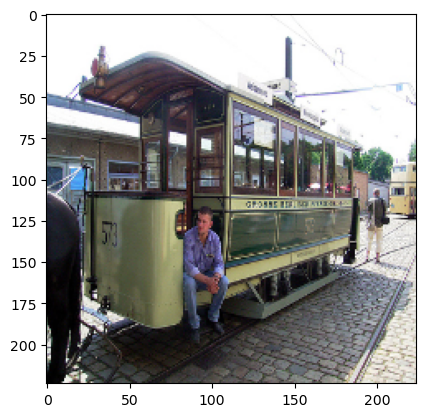

In [32]:
model.eval()
model.cpu()
i=3001
test_demo = model.greedy_decode(test_decoder_dataset[i][0].unsqueeze(0))
print(f'Real caption: {vectorizer.decode(test_decoder_dataset[i][1])}\nPredict: {vectorizer.decode(test_demo)}')
plt.imshow(test_decoder_dataset[i][0].int().permute(1, 2, 0))

In [33]:
import torchvision

image = transforms.Resize((224, 224))(torchvision.io.read_image('../../452184-poezd-rzhd-5.jpg')).float()
vectorizer.decode(model.greedy_decode(image.unsqueeze(0)))

'<SOS> поезд едущий по железнодорожным путям рядом с лесом <EOS>'

In [10]:
model.eval()
model.cpu()

outputs = []
captions = []

for idx in tqdm(list(range(1000)) + list(range(6000, 7000)) + list(range(12000, 13000))):
    caption = list(filter(lambda x: x != vectorizer.padding_idx, test_decoder_dataset[idx][1].tolist()))
    output = model.greedy_decode(test_decoder_dataset[idx][0].unsqueeze(0))
    outputs.append(output)
    captions.append(caption)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:58<00:00, 10.03it/s]


In [11]:
outputs = [outputs[i] for i in range(len(outputs)) if i not in ind]
captions = [captions[i] for i in range(len(captions)) if i not in ind]

In [12]:
def iou_score(outputs, captions):
    iou = 0
    for i in range(len(outputs)):
        iou += len(set(outputs[i]) & set(captions[i]))/len(set(outputs[i]) | set(captions[i]))
    return iou / len(captions)
iou_score(outputs, captions)

0.23460383987727698

In [13]:
import nltk
f = nltk.translate.bleu_score.SmoothingFunction().method3
scores = [nltk.translate.bleu_score.sentence_bleu([captions[i]], outputs[i], smoothing_function=f) for i in range(len(captions))]
print(max(scores))
print(sum(scores)/len(captions))

1.0
0.0922018831592572


In [14]:
scores = [nltk.translate.meteor_score.meteor_score([vectorizer.decode(captions[i]).split()], vectorizer.decode(outputs[i]).split()) for i in range(len(captions))]
print(max(scores))
print(sum(scores)/len(captions))

0.9997724169321802
0.22463547865490874


In [18]:
import numpy as np

np.array(scores)[np.argsort(np.array(scores))[::-1]][100:200]

array([0.99971065, 0.99971065, 0.99971065, 0.99971065, 0.99971065,
       0.99971065, 0.99971065, 0.99971065, 0.99902344, 0.99854227,
       0.98943985, 0.81790123, 0.78125   , 0.77119431, 0.74140848,
       0.73930921, 0.69882498, 0.69444444, 0.69394663, 0.68246654,
       0.67771084, 0.67244898, 0.66680355, 0.66573184, 0.65686552,
       0.65405405, 0.64637681, 0.64110493, 0.63125   , 0.625     ,
       0.625     , 0.625     , 0.62330623, 0.62224965, 0.61887255,
       0.61813187, 0.6109589 , 0.6027027 , 0.60040087, 0.59876781,
       0.59520657, 0.59466667, 0.5859375 , 0.58473824, 0.58228796,
       0.57244898, 0.55693069, 0.55515731, 0.5461165 , 0.5451895 ,
       0.54445252, 0.54373522, 0.54060606, 0.53913043, 0.53787617,
       0.53614027, 0.53298611, 0.53142857, 0.53046218, 0.52873563,
       0.52604167, 0.52470588, 0.52421652, 0.52025463, 0.51020408,
       0.50675676, 0.5018276 , 0.5011236 , 0.50108932, 0.4978355 ,
       0.496     , 0.49486461, 0.4934905 , 0.49145299, 0.49131

In [17]:
np.argsort(np.array(scores))[::-1][100:200]

array([2468, 2499, 2870, 2030, 2509, 2868, 2029, 2297, 2755, 2604, 2141,
       2571, 2420,   38, 1288, 1289, 2567, 2793,  222, 1902, 1856, 1898,
         60, 1980, 1607, 2150, 2838, 2242, 2019, 2231, 1829, 1418, 2741,
       1324, 1609, 2812, 2118, 2024, 1843,  514, 1140, 2163, 2533, 2550,
       1296, 2356, 1848, 1290, 1088, 1942,  876, 1491, 2714, 2413, 1615,
       1610, 2001, 2871, 1287,   44, 2524, 2522,  128, 1254, 1661, 1376,
        459, 1394, 1097,  672, 2834, 1412, 1582, 2651,  848,  727, 2205,
        174, 1188,  673, 1576, 2645, 1987, 1332,  498,  502, 2078, 2728,
         19, 1721, 1147, 2512, 2476, 1714, 2692, 1354, 1159,  423, 2170,
       2447], dtype=int64)

In [28]:
import json

with open(f'{name}_metric.json', 'w') as file:
    json.dump({'captions': captions, 'outputs': outputs}, file)

In [29]:
with open(f'{name}_results.json', 'w') as file:
    json.dump({'captions': [vectorizer.decode(caption) for caption in captions], 'outputs': [vectorizer.decode(output) for output in outputs]}, file)